# Fully Convolutional Networks for Semantic Segmentation

Run in the docker image found in https://github.com/waspinator/deep-learning-explorer


In [1]:
import os
import sys
import zipfile
import random
import math
import re
import time
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
import semantic.coco
import semantic.config
import semantic.models
import semantic.weights
import semantic.fcn
import semantic.evaluate

%matplotlib inline
%config IPCompleter.greedy=True

HOME_DIR = '/home/keras'
ROOT_DATA_DIR = os.path.join(HOME_DIR, "data")
WEIGHTS_DIR = os.path.join(HOME_DIR, "data/weights")

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Dataset

Your data should be in the [COCO style format](http://cocodataset.org/#download).

Organize the dataset using the following structure:

```
DATA_DIR
│
└───annotations
│   │   instances_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```

In [2]:
with zipfile.ZipFile(os.path.join(ROOT_DATA_DIR, "shapes.zip"), "r") as zip_ref:
    zip_ref.extractall(ROOT_DATA_DIR)

DATA_DIR = os.path.join(ROOT_DATA_DIR, "shapes")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

In [3]:
dataset_train = semantic.coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

dataset_validate = semantic.coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="shapes_validate", year="2018")
dataset_validate.prepare()

dataset_test = semantic.coco.CocoDataset()
dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
dataset_test.prepare()

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Configuration

In [4]:
class ShapesFcnConfig(semantic.config.Config):
    """Configuration for training on the Shapes dataset.
    Derives from the base Config class and overrides values specific
    to the Shapes dataset.
    """
    NAME = "shapes_fcn"

    IMAGES_PER_GPU = 32
    DATASET_SAMPLES = len(dataset_train.image_ids)
     
    STEPS_PER_EPOCH = DATASET_SAMPLES / IMAGES_PER_GPU

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + square, circle, triangle

    IMAGE_MAX_DIM = 320
    STEPS_PER_EPOCH = 128
    VALIDATION_STEPS = int(STEPS_PER_EPOCH / 10)
    BATCH_MOMENTUM = 0.9
    LEARNING_MOMENTUM = 0.9
    LR_BASE_BASE = 0.0001
    LR_POWER = 0.9
    WEIGHT_DECAY = 0.0001/2
    
config = ShapesFcnConfig()
config.display()


Configurations:
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     32
DATASET_SAMPLES                700
GPU_COUNT                      1
IMAGES_PER_GPU                 32
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LR_BASE                        0.0002
LR_BASE_BASE                   0.0001
LR_POWER                       0.9
MEAN_PIXEL                     [123.7 116.8 103.9]
NAME                           shapes_fcn
NUM_CLASSES                    4
STEPS_PER_EPOCH                128
TRAIN_BN                       False
VALIDATION_STEPS               12
WEIGHT_DECAY                   5e-05




# Load Model

In [5]:
model = semantic.fcn.FCN(config=config, model_dir=MODEL_DIR)

## Load weights

In [6]:
FCN_WEIGHTS = os.path.join(WEIGHTS_DIR, "fcn_resnet50_weights_tf_dim_ordering_tf_kernels.h5")
semantic.weights.transfer_FCN_ResNet50(FCN_WEIGHTS)

Already transformed


In [7]:
inititalize_weights_with = 'fcn_imagenet'  # imagenet or last

if inititalize_weights_with == 'imagenet':
    weights_path = semantic.models.resnet50_imagenet_weights_path()
elif inititalize_weights_with == 'fcn_imagenet':
    weights_path = semantic.models.fcn_resnet50_imagenet_weights_path()
else:
    weights_path = model.find_last()[1]

model.load_weights(weights_path, by_name=True)

## Train head

Train using only the final layer

In [8]:
epochs=5

### Learning Schedule 

In [9]:
learning_schedule = semantic.utils.create_learning_rate_schedule(
    epochs, config.LR_BASE, config.LR_POWER, mode='step_decay')

In [10]:
model.train(dataset_train, dataset_validate,
            learning_schedule,
            epochs,
            layers='head')

Selecting layers to train...
classify               (Conv2D)
Epoch 1/5
128/128 [==============================] - 228s 2s/step - loss: 1.6955 - sparse_accuracy_ignoring_last_label: 0.5277 - val_loss: 1.5061 - val_sparse_accuracy_ignoring_last_label: 0.4759
Epoch 2/5
128/128 [==============================] - 233s 2s/step - loss: 1.3169 - sparse_accuracy_ignoring_last_label: 0.6673 - val_loss: 1.4264 - val_sparse_accuracy_ignoring_last_label: 0.5584
Epoch 3/5
128/128 [==============================] - 229s 2s/step - loss: 1.2226 - sparse_accuracy_ignoring_last_label: 0.6989 - val_loss: 1.4443 - val_sparse_accuracy_ignoring_last_label: 0.5855
Epoch 4/5
128/128 [==============================] - 236s 2s/step - loss: 1.1895 - sparse_accuracy_ignoring_last_label: 0.7062 - val_loss: 1.4038 - val_sparse_accuracy_ignoring_last_label: 0.6164
Epoch 5/5
128/128 [==============================] - 238s 2s/step - loss: 1.1612 - sparse_accuracy_ignoring_last_label: 0.7143 - val_loss: 1.4041 - val_spa

## Fine tune

Train more slowly than before but using more or all the layers. Starts from the previous epoch. For example if you set the train part to have 4 epochs and you want to fine tune for 2, set the epochs below to 6

In [ ]:
epochs=7

### Learning Schedule 

In [ ]:
learning_schedule = semantic.utils.create_learning_rate_schedule(
    epochs, config.LR_BASE/10, config.LR_POWER, mode='step_decay')

In [ ]:
model.train(dataset_train, dataset_validate,
            learning_schedule,
            epochs,
            layers='all')

# Predict

Predict on a sample image

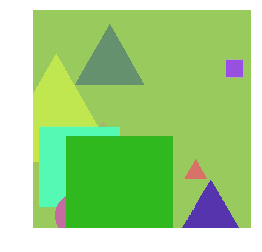

In [11]:
test_image_id = np.random.choice(dataset_test.image_ids, 1)[0]
image = Image.open(dataset_test.image_reference(test_image_id))
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(image)

In [12]:
prediction = model.predict(image)

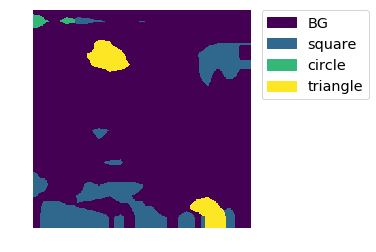

In [13]:
plt.figure(figsize=(8,4))
im = plt.imshow(prediction, interpolation='none')
values = np.unique(prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ matplotlib.patches.Patch(color=colors[i], label="{}".format(dataset_test.class_info[i]['name'])) for i in values ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
plt.axis('off')
plt.show()

# Evaluate

Get the Mean IoU for each class in the dataset

In [14]:
semantic.evaluate.evaluate(model, dataset_test)

{'square': [0.1313123575906],
 'circle': [0.31492097820924286],
 'triangle': [0.22119815978300272]}

In [16]:
coco_output = semantic.utils.result_to_coco(prediction, dataset_test.class_info, config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM)

In [19]:
dataset_train.class_weight

{0: 0.6245757457188198,
 1: 0.16082110268729075,
 2: 0.1188858904157366,
 3: 0.09571726117815291}